In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os

from neuropacks import ECOG
from pyuoi.decomposition import UoI_NMF
from scipy.optimize import nnls
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize 

from utils import *
%matplotlib inline

# Synthetic Case

In [2]:
# parameters
n_samples, n_features, true_rank = 1000, 50, 4
noise = 0.50

# initialize problem
W_true = np.random.uniform(low=0, high=3., size=(n_samples, true_rank))
H_true = np.random.uniform(low=0, high=3., size=(true_rank, n_features))
X = np.dot(W_true, H_true) + noise * np.random.rand(n_samples, n_features)

In [3]:
reps = 10
ranks = np.arange(1, 8)
error = np.zeros(ranks.size)

In [4]:
nmf = NMF(
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    init='random')

In [5]:
k_hat, errors = bi_cross_validator(X, nmf, ranks=ranks)

0
1
2
3
4
5
6
7
8
9


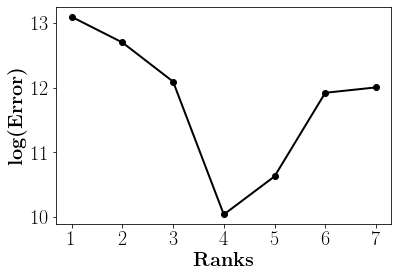

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(ranks, np.log(errors), color='k', linewidth=2, marker='o')
ax.set_xticks(ranks)
ax.tick_params(labelsize=20)
ax.set_xlabel(r'\textbf{Ranks}', fontsize=20)
ax.set_ylabel(r'\textbf{log(Error)}', fontsize=20)
plt.savefig('bcv_synthetic.pdf', bbox_inches='tight')

# ECoG

In [2]:
data_path = os.path.join('/storage/data/ecog/r32_b7.mat')
grid_path = os.path.join('/storage/data/ecog/grdid.mat')
ecog = ECOG(
    data_path=data_path,
    grid_path=grid_path
)

In [3]:
Y = ecog.get_response_matrix(
    bounds=(40, 60),
    band='HG'
)

In [4]:
stratify = ecog.get_design_matrix(form='frequency')

nmf = NMF(
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    init='random')

ranks = np.arange(1, 51)

In [5]:
# kill the dead indices
dead_indices = [19, 21, 0]
Y[:, dead_indices] = 0
Y = Y + np.abs(np.min(Y, axis=0, keepdims=True))

In [6]:
k_hat, errors = bi_cross_validator(Y, nmf, ranks=ranks, stratify=stratify)

0
1
2
3
4
5
6
7
8
9


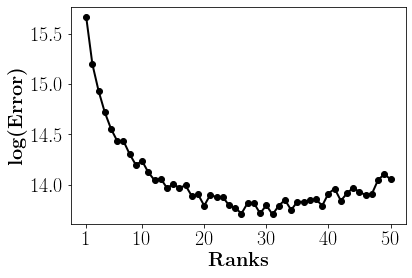

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(ranks, np.log(errors), color='k', linewidth=2, marker='o')
ax.set_xticks(np.array([1, 10, 20, 30, 40, 50]))
ax.tick_params(labelsize=20)
ax.set_xlabel(r'\textbf{Ranks}', fontsize=20)
ax.set_ylabel(r'\textbf{log(Error)}', fontsize=20)
plt.savefig('bcv_nmf.pdf', bbox_inches='tight')

# Plot ECoG Bases

In [2]:
data_path = os.path.join('/storage/data/ecog/r32_b7.mat')
grid_path = os.path.join('/storage/data/ecog/grdid.mat')
ecog = ECOG(
    data_path=data_path,
    grid_path=grid_path
)

In [3]:
Y = ecog.get_response_matrix(
    bounds=(40, 60),
    band='HG'
)

In [4]:
# kill the dead indices
dead_indices = [19, 21, 0]
Y = Y + np.abs(np.min(Y, axis=0, keepdims=True))
Y[:, dead_indices] = 0

In [5]:
nmf = NMF(
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    init='random')
nmf.set_params(n_components=30)
nmf.fit(Y)

NMF(alpha=0.0, beta_loss='kullback-leibler', init='random', l1_ratio=0.0,
    max_iter=1000, n_components=30, random_state=None, shuffle=False,
    solver='mu', tol=0.0001, verbose=0)

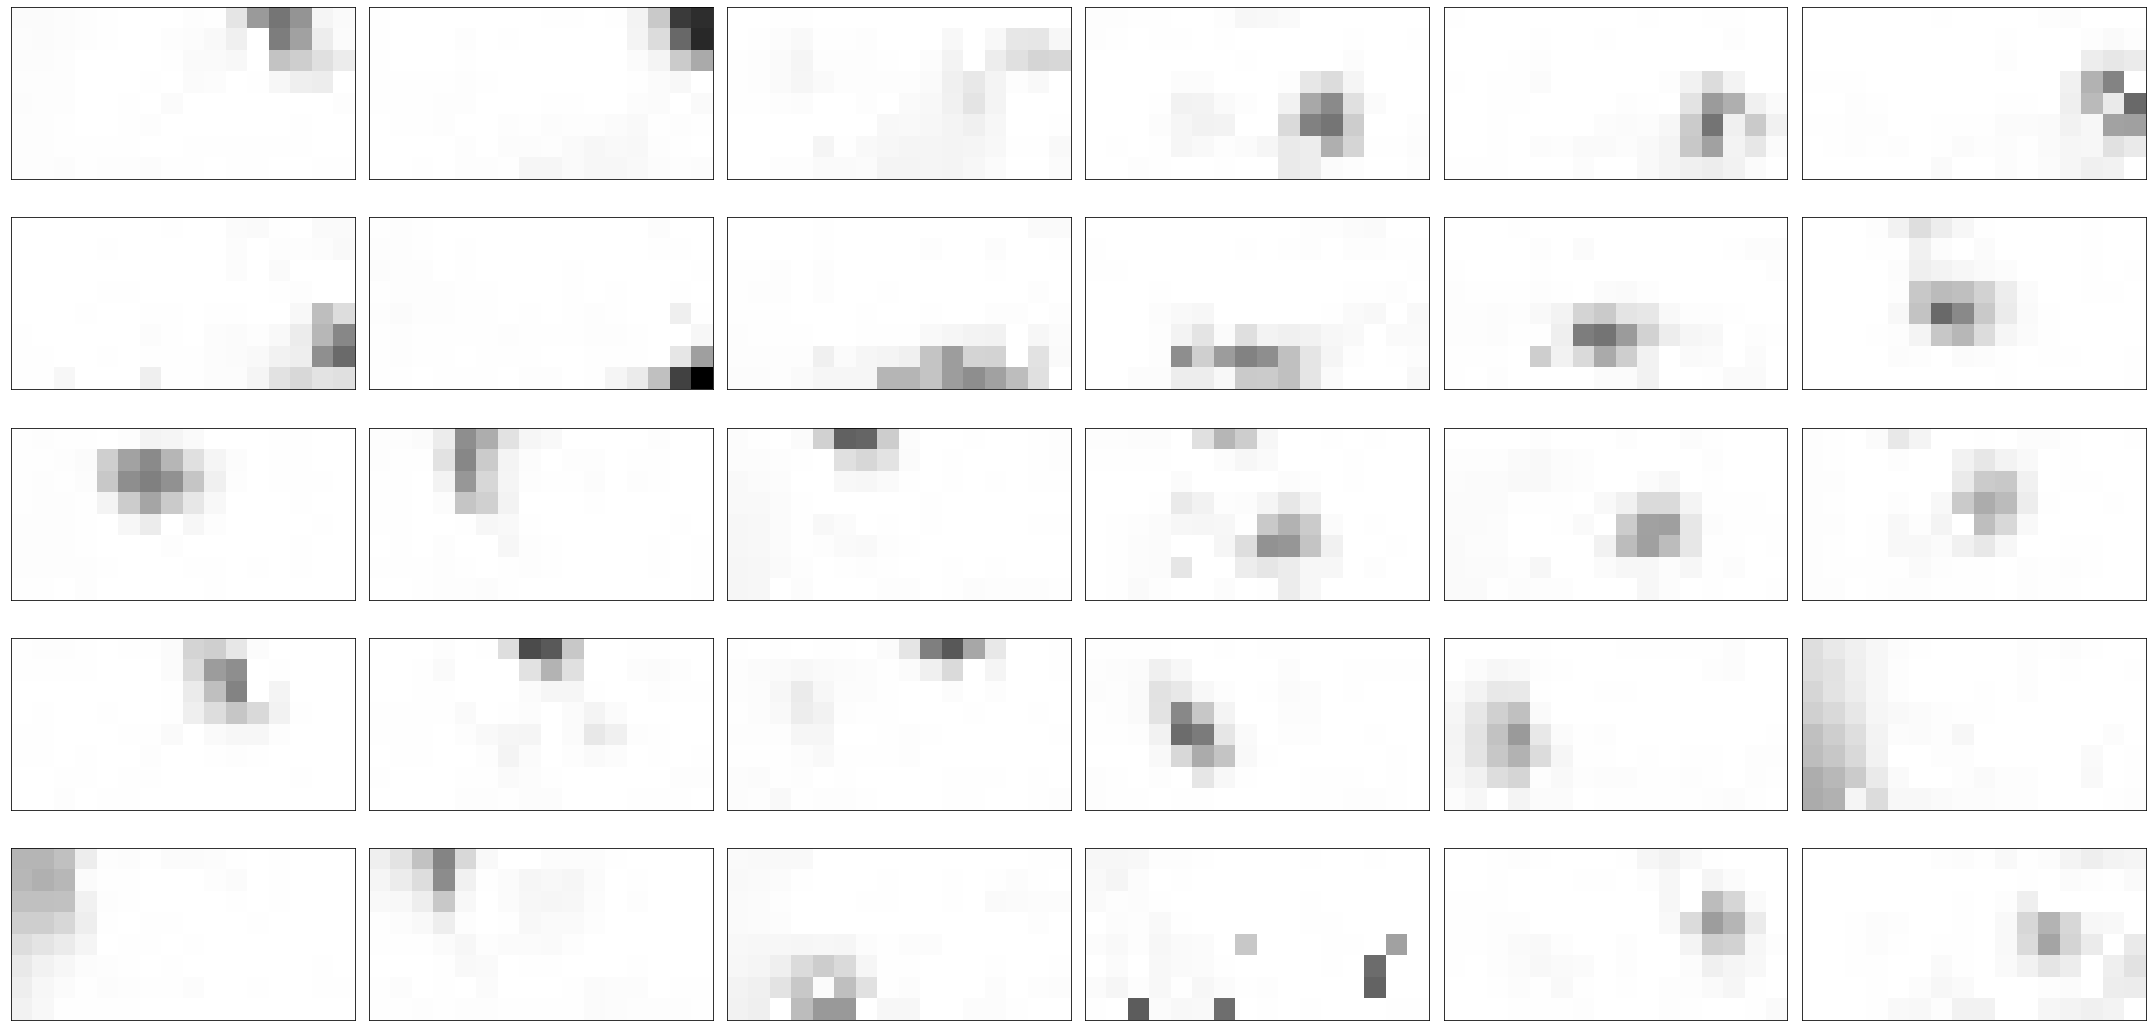

In [9]:
fig, axes = plot_ecog_bases(nmf.components_, ecog, n_cols=6)
plt.tight_layout()
plt.savefig('bases_min_cv.pdf', bbox_inches='tight')